## Dogs v Cats

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
import skimage

In [2]:
PATH = "/home/akash/data/dogscats/"
sz = 224
arch = resnet34
bs = 64

In [3]:
m = arch(True)

In [4]:
m

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (b

In [5]:
### last 3 layers
children(m)[-3:]

[Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
     (relu): ReLU(inplace)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
     (downsample): Sequential(
       (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
     )
   )
   (1): BasicBlock(
     (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
     (relu): ReLU(inplace)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
   )
   (2): BasicBlock(
     (conv1): Conv2d(512, 512, kernel_

In [6]:
a = [1,2,3,4,5,6]
a[:-2]

[1, 2, 3, 4]

In [7]:
# we remove the last 2 layers an add our own layers
# Conv2D with 2 filters. One dog one cat.
m = nn.Sequential(*children(m)[:-2], 
                  nn.Conv2d(512, 2, 3, padding=1), 
                  nn.AdaptiveAvgPool2d(1), Flatten(), 
                  nn.LogSoftmax())

In [8]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs)

In [9]:
learn = ConvLearner.from_model_data(m, data)

In [10]:
#### last four layers
children(m)[-4:]

[Conv2d(512, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 AdaptiveAvgPool2d(output_size=1),
 Flatten(
 ),
 LogSoftmax()]

In [11]:
learn.freeze_to(-4)

In [12]:
m[-1].trainable

True

In [13]:
m[-4].trainable

True

In [14]:
learn.fit(0.01, 1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.157235   0.122895   0.986     



[array([0.12289]), 0.986]

In [15]:
learn.fit(0.01, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.061736   0.098678   0.989     



[array([0.09868]), 0.989]

## Class Activation Maps (CAM)

In [16]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [26]:
x,y = next(iter(data.val_dl))

In [27]:
x.size(), y.size()

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

In [29]:
x,y = x[None,1], y[None,1] 

In [30]:
x.size(), y.size()

(torch.Size([1, 3, 224, 224]), torch.Size([1]))

In [31]:
vx = Variable(x.cuda(), requires_grad=True)

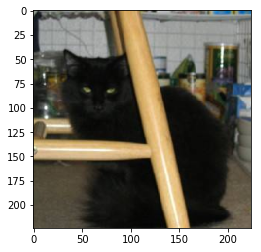

In [32]:
dx = data.val_ds.denorm(x)[0]
plt.imshow(dx);

In [33]:
sfs = [SaveFeatures(o) for o in [m[-7], m[-6], m[-5], m[-4]]]

In [34]:
%time py = m(Variable(x.cuda()))

CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 12 ms


In [35]:
for o in sfs: o.remove()

In [36]:
[o.features.size() for o in sfs]

[torch.Size([1, 128, 28, 28]),
 torch.Size([1, 256, 14, 14]),
 torch.Size([1, 512, 7, 7]),
 torch.Size([1, 2, 7, 7])]

In [37]:
py = np.exp(to_np(py)[0]); py

array([1., 0.], dtype=float32)

In [38]:
feat = np.maximum(0,to_np(sfs[3].features[0]))
feat.shape

(2, 7, 7)

In [39]:
f2=np.dot(np.rollaxis(feat,0,3), py)
f2-=f2.min()
f2/=f2.max()
f2

array([[0.37345, 0.51764, 0.49937, 0.3607 , 0.28585, 0.24512, 0.15155],
       [0.62925, 0.87888, 0.83619, 0.57003, 0.41195, 0.33622, 0.2049 ],
       [0.71468, 1.     , 0.93465, 0.62319, 0.43321, 0.33324, 0.21318],
       [0.64151, 0.89513, 0.84886, 0.56386, 0.34081, 0.22248, 0.13527],
       [0.46351, 0.67716, 0.66494, 0.45375, 0.2371 , 0.14149, 0.08063],
       [0.31951, 0.49327, 0.48778, 0.31004, 0.10573, 0.02569, 0.01855],
       [0.15251, 0.22202, 0.19508, 0.08601, 0.     , 0.     , 0.     ]], dtype=float32)

In [45]:
import skimage.transform

/home/akash/.conda/envs/fastai/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/akash/.conda/envs/fastai/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


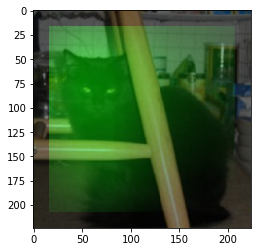

In [46]:
plt.imshow(dx)
plt.imshow(skimage.transform.resize(f2, dx.shape), alpha=0.5, cmap='hot');

## Model

In [47]:
learn.unfreeze()
learn.bn_freeze(True)

In [48]:
# 12 layer groups call for 12 lrs
lr=np.array([[1e-6]*4,[1e-4]*4,[1e-2]*4]).flatten()

In [49]:
learn.fit(lr, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.04689    0.064801   0.989     
    1      0.040374   0.045071   0.9905                       



[array([0.04507]), 0.9905]

In [50]:
log_preds,y = learn.TTA()
preds = np.mean(np.exp(log_preds),0)
accuracy_np(preds,y)

0.9925

In [51]:
learn.fit(lr, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.024875   0.043815   0.9885    
    1      0.021502   0.039936   0.9895                       



[array([0.03994]), 0.9895]

In [52]:
log_preds,y = learn.TTA()
preds = np.mean(np.exp(log_preds),0)
accuracy_np(preds,y)

0.992